In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import accuracy_score

In [2]:
# @param X: pandas.DataFrame
# @param featureSel: int
# @return X: pandas.DataFrame
def featureEng(X, featureSel=None):
    # Feature Engineering
    if not featureSel or featureSel == 0:
        return X
    if featureSel == 1:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
    elif featureSel == 2:
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 3:
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        attriToDrop = ['PTS_A', 'PTS_B']
        X = X.drop(columns=attriToDrop)
    elif featureSel == 4:
        attriToDrop = [
            'FGM_A', 'FGA_A', '3PM_A', '3PA_A', 'FTM_A', 'FTA_A', 'OREB_A', 'DREB_A', 'PF_A', 
            'FGM_B', 'FGA_B', '3PM_B', '3PA_B', 'FTM_B', 'FTA_B', 'OREB_B', 'DREB_B', 'PF_B'
        ]
        X['PTS_DIFF'] = X['PTS_A'] - X['PTS_B']
        X['STL+BLK_A'] = X['STL_A'] + X['BLK_A']
        X['STL+BLK_B'] = X['STL_B'] + X['BLK_B']
        attriToDrop += ['PTS_A', 'PTS_B', 'STL_A', 'STL_B', 'BLK_A', 'BLK_B']
        X = X.drop(columns=attriToDrop)
    return X

In [3]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# featureExtraction() outputs X, Y for model training.
def featureExtraction(dfFile, dateStart='1000-01-01', dateEnd='2999-12-31', period=5, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selection
    df = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Get label Y
    Y = df[['W/L_A']]
    Y = Y.rename(columns={'W/L_A': 'Label'})
    
    # Get averaged attributes X
    for idx, row in df.iterrows():
        df_sel = df.loc[df.Date_A <= row['Date_A'], :].reset_index(drop=True)
        
        # Process of Team_A
        gamePlayed_A = df_sel.loc[df_sel.Team_A == row['Team_A'], :]
        if len(gamePlayed_A) == 1:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_A) < period:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_A), 0:24].reset_index(drop=True)
        else:
            X_A = gamePlayed_A.loc[(gamePlayed_A.Team_A == row['Team_A']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Process of Team_B
        gamePlayed_B = df_sel.loc[df_sel.Team_A == row['Team_B'], :]
        if len(gamePlayed_B) == 1:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[0:1, 0:24].reset_index(drop=True)
        elif len(gamePlayed_B) < period:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:len(gamePlayed_B), 0:24].reset_index(drop=True)
        else:
            X_B = gamePlayed_B.loc[(gamePlayed_B.Team_A == row['Team_B']), :].sort_values(by=['Date_A'], ascending=False).iloc[1:period+1, 0:24].reset_index(drop=True)
        
        # Drop unnecessary attributes
        colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
        X_A = X_A.drop(columns=colToDrop)
        X_B = X_B.drop(columns=colToDrop)
        
        # Rename X_B's columns
        X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
        
        # Get X_single = [Home/Away_A + X_A + X_B]
        X_single = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
        X_single = pd.concat([pd.DataFrame(data={'Home/Away_A': [row['Home/Away_A']]}), X_single], axis=1)
        
        # Concatenation dataFrames by row
        if idx == 0:
            X = X_single
        else:
            X = pd.concat([X, X_single], ignore_index=True)
        
    # Feature Engineering
    X = featureEng(X, featureSel)
        
    return X, Y

In [4]:
# Feature Extraction
dfFile = 'nba_preprocessed.csv'
dateStart = '2013-08-01'
dateEnd = '2018-04-13'
period = 5
featureSel = 3
X, Y = featureExtraction(dfFile, dateStart, dateEnd, period, featureSel)


In [5]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str
# @param homeAway: int (None for played game prediction)
# @param featureSel: int
# @return X: pandas.DataFrame
def attriGen(df, date, period, Team_A, Team_B, homeAway=None, featureSel=None):
    # True Home/Away at the game day
    if homeAway is None:
        df_gameDay = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)
        homeAway = int(df_gameDay['Home/Away_A'])
    
    # Date selections
    df = df.loc[df.Date_A < date, :].reset_index(drop=True)
    X_A = df.loc[(df.Team_A == Team_A), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    X_B = df.loc[(df.Team_A == Team_B), :].sort_values(by=['Date_A'], ascending=False).iloc[0:period, 0:24].reset_index(drop=True)
    
    # Drop unnecessary attributes
    colToDrop = ['Home/Away_A'] + ['Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A']
    X_A = X_A.drop(columns=colToDrop)
    X_B = X_B.drop(columns=colToDrop)
    
    # Rename X_away's columns
    X_B = X_B.rename(columns=lambda x: x[0:-2] + '_B')
    
    # Get X = [Home/Away_A + X_A + X_B]
    X = pd.DataFrame(data=pd.concat([X_A.mean(), X_B.mean()])).transpose()
    X = pd.concat([pd.DataFrame(data={'Home/Away_A': [homeAway]}), X], axis=1)
    
    # Feature Engineering
    X = featureEng(X, featureSel)
    
    return X

In [6]:
# @param dfFile: pandas.DataFrame (from 'nba_preprocessed.csv')
# @param date: str in the format of 'YYYY-MM-DD'
# @param Team_A, Team_B: str
# @param featureSel: int
# @return X_groundTruth, Y_groundTruth: pandas.DataFrame
def groundTruthGen(df, date, Team_A, Team_B, featureSel=None):
    # Date selections
    df = df.loc[(df.Date_A == date) & (df.Team_A == Team_A) & (df.Team_B == Team_B), :].reset_index(drop=True)

    # Get label Y
    Y_groundTruth = df[['W/L_A']]
    Y_groundTruth = Y_groundTruth.rename(columns={'W/L_A': 'Label'})
    
    # Drop unnecessary attributes
    colToDrop = [
        'Team_A', 'Date_A', 'W/L_A', 'Score_A', 'Opponent_A', 
        'Team_B', 'Date_B', 'W/L_B', 'Home/Away_B', 'Score_B', 'Opponent_B'
    ]
    X_groundTruth = df.drop(columns=colToDrop)
    
    # Feature Engineering
    X_groundTruth = featureEng(X_groundTruth, featureSel)
    
    return X_groundTruth, Y_groundTruth

In [7]:
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return X, Y: pandas.DataFrame
# gameAttriGen() outputs X_attri, Y_truth for game prediction.
def gameAttriGen(dfFile, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None):
    df = pd.read_csv(dfFile)
    
    # Date selections
    df_sel = df.loc[(df.Date_A >= dateStart) & (df.Date_A <= dateEnd), :].reset_index(drop=True)
    
    # Generate df_sel which includes [date, Team_A, Team_B] columns
    if Team_A and Team_B:
        df_sel = df_sel.loc[(df_sel.Team_A == Team_A) & (df_sel.Opponent_A == Team_B), :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif Team_A and not Team_B:
        df_sel = df_sel.loc[df_sel.Team_A == Team_A, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and Team_B:
        df_sel = df_sel.loc[df_sel.Opponent_A == Team_B, :].reset_index(drop=True)[['Date_A', 'Team_A', 'Opponent_A']]
    elif not Team_A and not Team_B:
        df_sel = df_sel[['Date_A', 'Team_A', 'Opponent_A']]
        # Delete duplicates: (Team_A vs Team_B) is the same as (Team_B vs Team_A). Remove one to avoid double count.
        df_new = pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'])
        LUT = {}
        for date, x, y in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
            if (date + x + y) in LUT:
                df_new = pd.concat([df_new, pd.DataFrame(columns=['Date_A', 'Team_A', 'Opponent_A'], data=[[date, x, y]])], ignore_index=True)
            else:
                LUT[date + x + y] = 1
                LUT[date + y + x] = 1
        df_sel = df_new
    
    # W/L prediction
    X_attri = Y_truth = None
    for date, Team_A, Team_B in zip(df_sel['Date_A'], df_sel['Team_A'], df_sel['Opponent_A']):
        X_toBePredicted = attriGen(df, date, period, Team_A, Team_B, None, featureSel)
        X_groundTruth, Y_groundTruth = groundTruthGen(df, date, Team_A, Team_B, featureSel)
        if X_attri is None and Y_truth is None:
            X_attri = X_toBePredicted
            Y_truth = Y_groundTruth
        else:
            X_attri = pd.concat([X_attri, X_toBePredicted], ignore_index=True)
            Y_truth = pd.concat([Y_truth, Y_groundTruth], ignore_index=True)
        
    return X_attri, Y_truth

In [8]:
from sklearn.metrics import accuracy_score
# @param dfFile: pandas.DataFrame ('nba_preprocessed.csv')
# @param modelsLUT: dict in the format of {'modelName': model}
# @param dateStart, dateEnd: str in the format of 'YYYY-MM-DD'
# @param period: int (Number of previous games to be considered)
# @param Team_A, Team_B: str (If both are None, predict all games within the date range)
# @param featureSel: int
# @return None
# gamePrediction() prints the predicted game W/L results.
def gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period=5, Team_A=None, Team_B=None, featureSel=None, is_print_result=0):
    X_attri, Y_truth = gameAttriGen(dfFile, dateStart, dateEnd, period, Team_A, Team_B, featureSel)
    
    resultLUT, accuLUT = {}, {}
    for model in modelsLUT:
        resultLUT[model] = modelsLUT[model].predict(X_attri)
        #accuLUT[model] = accuracy_score(Y_truth, modelsLUT[model].predict(X_attri))
        accuLUT[model] = accuracy_score(Y_truth, resultLUT[model])
    
    if(is_print_result):
        print('---------- Prediction Accuracy ----------')
        print('featureSel =', featureSel)
        for x in accuLUT:
            print(x, '=', accuLUT[x]*100, '%')
        print('------------------------------------')
    return accuLUT

In [9]:
# Model Training
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier

logiRegr = LogisticRegression()
logiRegr.fit(X, Y)

supVecMachine = SVC(kernel='linear', probability=True)
supVecMachine.fit(X, Y)

xgbc = xgb.XGBClassifier()
xgbc.fit(X, Y)

naiveBayes = GaussianNB()
naiveBayes.fit(X, Y)

randomForest = RandomForestClassifier()
randomForest.fit(X, Y)

gbdt = GradientBoostingClassifier()
gbdt.fit(X,Y)

lgbm = LGBMClassifier()
lgbm.fit(X, Y)

adaBoost = AdaBoostClassifier()
adaBoost.fit(X, Y)

# Prediction
dateStart = '2018-04-14'
dateEnd = '2018-06-01'
Team_A = None
Team_B = None
modelsLUT = {
    'logiRegr': logiRegr,
    'supVecMachine': supVecMachine,
    'xgbc': xgbc,
    'naiveBayes': naiveBayes,
    'randomForest': randomForest,
    'gbdt': gbdt,
    'lgbm': lgbm,
    'adaBoost': adaBoost, 
}

# Training Data Volume
print('---------- Training Data Volume ----------')
print('# of data =', len(X))
print('------------------------------------')

# W/L prediction
gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel)

---------- Training Data Volume ----------
# of data = 11702
------------------------------------


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


{'adaBoost': 0.6708860759493671,
 'gbdt': 0.7468354430379747,
 'lgbm': 0.6962025316455697,
 'logiRegr': 0.7088607594936709,
 'naiveBayes': 0.5949367088607594,
 'randomForest': 0.6455696202531646,
 'supVecMachine': 0.7088607594936709,
 'xgbc': 0.759493670886076}

## Parameter Search

In [10]:
def ParameterSearch(X=None, Y=None, dateStart='2018-04-14', dateEnd='2018-06-01', Team_A=None, Team_B=None, 
                    param_name=None, param_list=None, model=None, title=None, **other_setting):
    total_acc = []
    max_acc = -1
    max_param_val = -1
    total_len = len(param_list)
    count_prog = 0
    for val in param_list:
        other_setting[param_name] = val
        model.set_params(**other_setting)
        model.fit(X, Y.values.ravel())
    
        modelsLUT = {
            'model': model
        }
        ret_acc = gamePrediction(dfFile, modelsLUT, dateStart, dateEnd, period, Team_A, Team_B, featureSel, 0)
    
        for model_name in modelsLUT:
            total_acc.append(ret_acc[model_name])
            if(total_acc[-1] > max_acc):
                max_acc = total_acc[-1]
                max_param_val = val
        count_prog += 1
        print('Progress = {x}%'.format(x = count_prog/total_len*100))
    
    print(f'max_acc = {max_acc}, with {param_name} = {max_param_val}')
    plt.plot(param_list, total_acc)
    plt.xlabel(f' {title} ')
    plt.ylabel(' Accuracy ')
    plt.show()  

### Logistic Regressor

Progress = 2.5%
Progress = 5.0%
Progress = 7.5%
Progress = 10.0%
Progress = 12.5%
Progress = 15.0%
Progress = 17.5%
Progress = 20.0%
Progress = 22.5%
Progress = 25.0%
Progress = 27.500000000000004%
Progress = 30.0%
Progress = 32.5%
Progress = 35.0%
Progress = 37.5%
Progress = 40.0%
Progress = 42.5%
Progress = 45.0%
Progress = 47.5%
Progress = 50.0%
Progress = 52.5%
Progress = 55.00000000000001%
Progress = 57.49999999999999%
Progress = 60.0%
Progress = 62.5%
Progress = 65.0%
Progress = 67.5%
Progress = 70.0%
Progress = 72.5%
Progress = 75.0%
Progress = 77.5%
Progress = 80.0%
Progress = 82.5%
Progress = 85.0%
Progress = 87.5%
Progress = 90.0%
Progress = 92.5%
Progress = 95.0%
Progress = 97.5%
Progress = 100.0%
max_acc = 0.7088607594936709, with C = 0.01


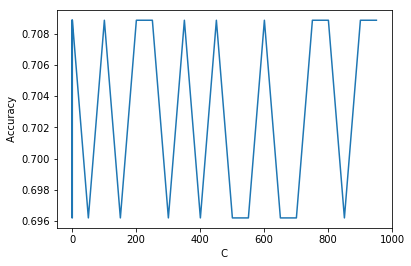

In [11]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[x/100 for x in range(1, 100, 5)]+[x for x in range(1, 1000, 50)], model=LogisticRegression()
                , title = 'C', max_iter=300)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.7088607594936709, with max_iter = 10


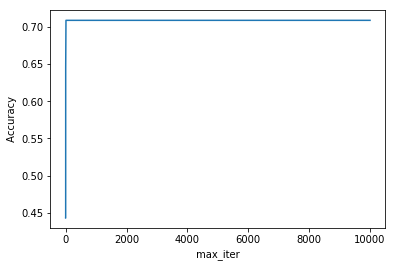

In [12]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_iter'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=LogisticRegression()
                , title = 'max_iter', C=0.01)

### Result : C = 0.01, max_iter = 10

### SVM

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.7341772151898734, with C = 0.1


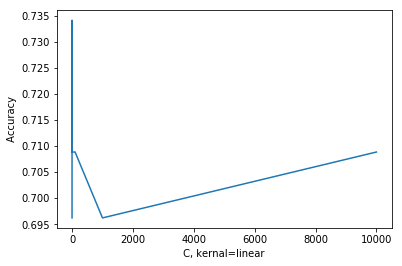

In [13]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='C, kernal=linear', kernel='linear', probability=True)

Progress = 2.5%
Progress = 5.0%
Progress = 7.5%
Progress = 10.0%
Progress = 12.5%
Progress = 15.0%
Progress = 17.5%
Progress = 20.0%
Progress = 22.5%
Progress = 25.0%
Progress = 27.500000000000004%
Progress = 30.0%
Progress = 32.5%
Progress = 35.0%
Progress = 37.5%
Progress = 40.0%
Progress = 42.5%
Progress = 45.0%
Progress = 47.5%
Progress = 50.0%
Progress = 52.5%
Progress = 55.00000000000001%
Progress = 57.49999999999999%
Progress = 60.0%
Progress = 62.5%
Progress = 65.0%
Progress = 67.5%
Progress = 70.0%
Progress = 72.5%
Progress = 75.0%
Progress = 77.5%
Progress = 80.0%
Progress = 82.5%
Progress = 85.0%
Progress = 87.5%
Progress = 90.0%
Progress = 92.5%
Progress = 95.0%
Progress = 97.5%
Progress = 100.0%
max_acc = 0.7341772151898734, with C = 0.06


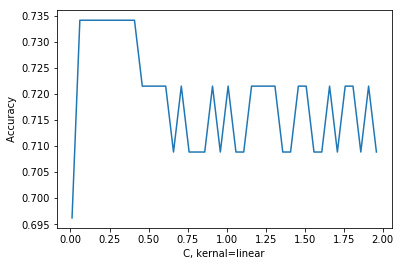

In [14]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[x/100 for x in range(1, 200, 5)], model=SVC()
                , title='C, kernal=linear', kernel='linear', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6835443037974683, with C = 0.01


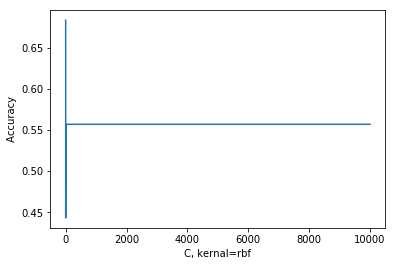

In [15]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000]
                , model=SVC(), title='C, kernal=rbf'
                , kernel='rbf', gamma=1, probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6835443037974683, with gamma = 0.1


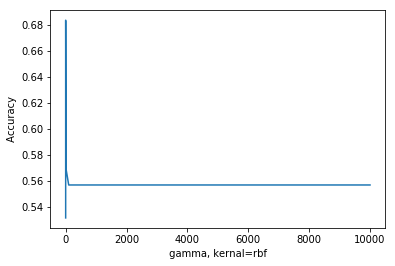

In [16]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='gamma'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=SVC()
                , title='gamma, kernal=rbf', C=0.01, kernel='rbf', probability=True)

Progress = 5.0%
Progress = 10.0%
Progress = 15.0%
Progress = 20.0%
Progress = 25.0%
Progress = 30.0%
Progress = 35.0%
Progress = 40.0%
Progress = 45.0%
Progress = 50.0%
Progress = 55.00000000000001%
Progress = 60.0%
Progress = 65.0%
Progress = 70.0%
Progress = 75.0%
Progress = 80.0%
Progress = 85.0%
Progress = 90.0%
Progress = 95.0%
Progress = 100.0%
max_acc = 0.6835443037974683, with gamma = 0.11


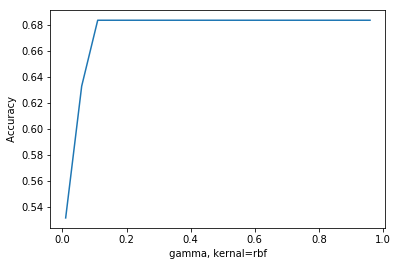

In [18]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='gamma'
                , param_list=[x/100 for x in range(1, 100, 5)], model=SVC()
                , title='gamma, kernal=rbf', C=0.01, kernel='rbf', probability=True)

Progress = 14.285714285714285%
Progress = 28.57142857142857%
Progress = 42.857142857142854%
Progress = 57.14285714285714%
Progress = 71.42857142857143%
Progress = 85.71428571428571%
Progress = 100.0%
max_acc = 0.6835443037974683, with C = 0.01


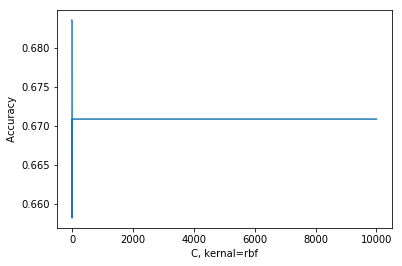

In [19]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='C'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000]
                , model=SVC(), title='C, kernal=rbf'
                , kernel='rbf', gamma=0.11, probability=True)

### Result = kernel='linear', C = 0.06

### XGBClassifier

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 6.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 18.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 25.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 31.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 37.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 43.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 56.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 62.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 68.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 81.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 93.75%
Progress = 100.0%
max_acc = 0.7721518987341772, with max_depth = 5


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


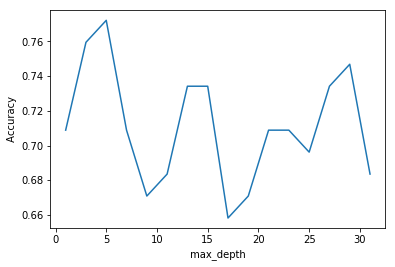

In [20]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.1, n_estimators=100)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 20.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 40.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 60.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 80.0%
Progress = 100.0%
max_acc = 0.7721518987341772, with n_estimators = 100


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


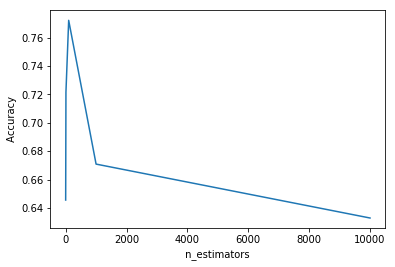

In [21]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=[1, 10, 100, 1000, 10000], model=xgb.XGBClassifier()
                , title='n_estimators', learning_rate=0.1, max_depth=5)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 2.0408163265306123%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 4.081632653061225%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 6.122448979591836%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 8.16326530612245%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 10.204081632653061%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.244897959183673%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 14.285714285714285%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 16.3265306122449%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 18.367346938775512%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 20.408163265306122%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 22.448979591836736%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 24.489795918367346%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 26.53061224489796%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 28.57142857142857%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 30.612244897959183%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 32.6530612244898%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 34.69387755102041%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 36.734693877551024%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 38.775510204081634%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 40.816326530612244%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 42.857142857142854%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 44.89795918367347%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 46.93877551020408%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 48.97959183673469%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 51.02040816326531%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 53.06122448979592%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 55.10204081632652%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 57.14285714285714%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 59.183673469387756%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 61.224489795918366%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 63.26530612244898%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 65.3061224489796%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 67.3469387755102%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 69.38775510204081%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 71.42857142857143%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 73.46938775510205%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.51020408163265%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 77.55102040816327%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 79.59183673469387%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 81.63265306122449%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 83.6734693877551%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 85.71428571428571%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.75510204081633%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 89.79591836734694%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 91.83673469387756%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 93.87755102040816%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 95.91836734693877%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 97.95918367346938%
Progress = 100.0%
max_acc = 0.7848101265822784, with n_estimators = 230


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


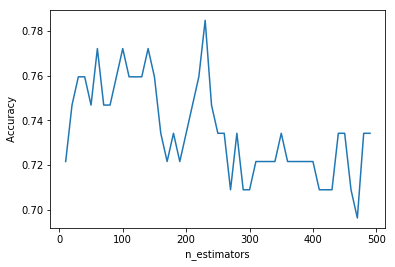

In [22]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(10, 500, 10), model=xgb.XGBClassifier()
                , title='n_estimators', learning_rate=0.1, max_depth=5)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 6.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 18.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 25.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 31.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 37.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 43.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 56.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 62.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 68.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 81.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 93.75%
Progress = 100.0%
max_acc = 0.7848101265822784, with max_depth = 5


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


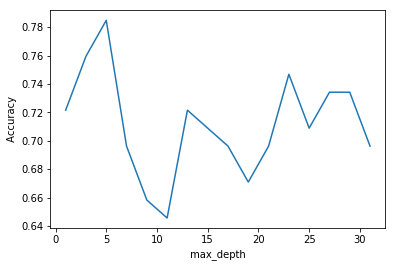

In [23]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.1, n_estimators=230)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 14.285714285714285%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 28.57142857142857%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 42.857142857142854%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 57.14285714285714%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 71.42857142857143%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 85.71428571428571%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 100.0%
max_acc = 0.7848101265822784, with learning_rate = 0.1


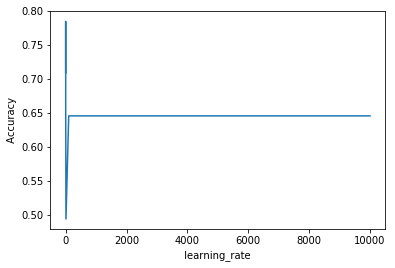

In [25]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[0.01, 0.1, 1, 10, 100, 1000, 10000], model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=5, n_estimators=230)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 5.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 10.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 15.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 20.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 25.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 30.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 35.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 40.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 45.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 55.00000000000001%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 60.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 65.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 70.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 80.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 85.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 90.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 95.0%
Progress = 100.0%
max_acc = 0.759493670886076, with learning_rate = 0.06


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


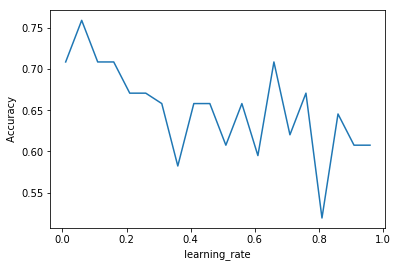

In [26]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[x/100 for x in range(1, 100, 5)], model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=5, n_estimators=230)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 6.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 18.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 25.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 31.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 37.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 43.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 56.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 62.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 68.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 81.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 93.75%
Progress = 100.0%
max_acc = 0.759493670886076, with max_depth = 3


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


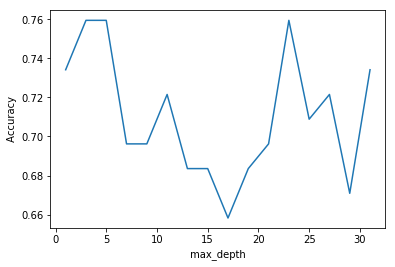

In [27]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.06, n_estimators=230)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 2.0408163265306123%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 4.081632653061225%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 6.122448979591836%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 8.16326530612245%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 10.204081632653061%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.244897959183673%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 14.285714285714285%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 16.3265306122449%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 18.367346938775512%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 20.408163265306122%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 22.448979591836736%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 24.489795918367346%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 26.53061224489796%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 28.57142857142857%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 30.612244897959183%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 32.6530612244898%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 34.69387755102041%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 36.734693877551024%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 38.775510204081634%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 40.816326530612244%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 42.857142857142854%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 44.89795918367347%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 46.93877551020408%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 48.97959183673469%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 51.02040816326531%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 53.06122448979592%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 55.10204081632652%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 57.14285714285714%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 59.183673469387756%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 61.224489795918366%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 63.26530612244898%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 65.3061224489796%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 67.3469387755102%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 69.38775510204081%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 71.42857142857143%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 73.46938775510205%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.51020408163265%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 77.55102040816327%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 79.59183673469387%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 81.63265306122449%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 83.6734693877551%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 85.71428571428571%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.75510204081633%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 89.79591836734694%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 91.83673469387756%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 93.87755102040816%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 95.91836734693877%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 97.95918367346938%
Progress = 100.0%
max_acc = 0.7721518987341772, with n_estimators = 270


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


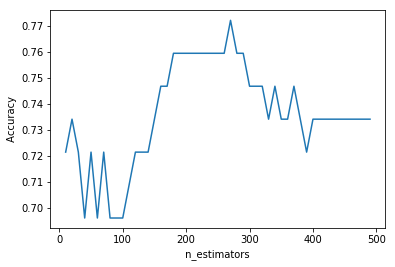

In [29]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='n_estimators'
                , param_list=range(10, 500, 10), model=xgb.XGBClassifier()
                , title='n_estimators', learning_rate=0.06, max_depth=3)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 6.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 18.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 25.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 31.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 37.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 43.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 56.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 62.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 68.75%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 81.25%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 93.75%
Progress = 100.0%
max_acc = 0.7721518987341772, with max_depth = 3


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


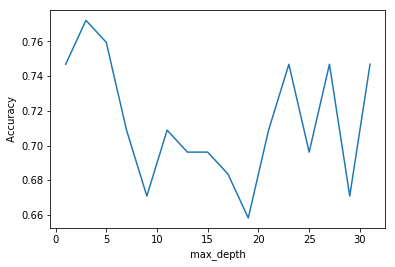

In [30]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='max_depth'
                , param_list=[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31], model=xgb.XGBClassifier()
                , title='max_depth', learning_rate=0.06, n_estimators=270)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 16.666666666666664%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 33.33333333333333%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 66.66666666666666%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 83.33333333333334%
Progress = 100.0%
max_acc = 0.7721518987341772, with learning_rate = 1000


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


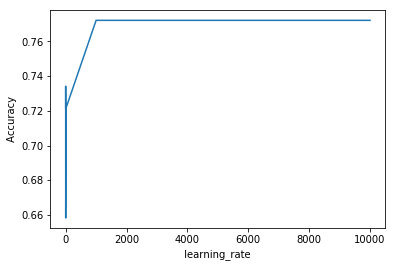

In [31]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=[0.01, 0.1, 1, 10, 1000, 10000], model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=3, n_estimators=270)

/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 2.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 5.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 7.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 10.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 12.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 15.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 17.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 20.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 22.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 25.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 27.500000000000004%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 30.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 32.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 35.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 37.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 40.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 42.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 45.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 47.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 50.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 52.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 55.00000000000001%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 57.49999999999999%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 60.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 62.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 65.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 67.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 70.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 72.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 75.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 77.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 80.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 82.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 85.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 87.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 90.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 92.5%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 95.0%


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Progress = 97.5%
Progress = 100.0%
max_acc = 0.7721518987341772, with learning_rate = 1000


/home/coslate/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


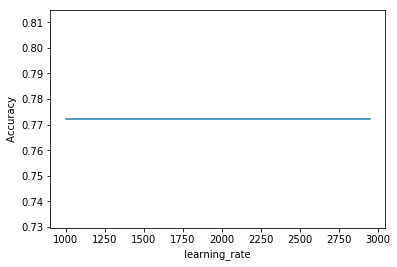

In [32]:
ParameterSearch(X, Y, dateStart='2018-04-14', dateEnd='2018-06-01'
                , Team_A=None, Team_B=None, param_name='learning_rate'
                , param_list=range(1000, 3000, 50), model=xgb.XGBClassifier()
                , title='learning_rate', max_depth=3, n_estimators=270)

### Result : max_depth=3, n_estimators=270, learning_rate = 1000